In [391]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn

In [392]:
def make_dataset(time_steps=1000, frequency=0.01, num_features=5, output_length=10, shift_steps=10, forecast_noise_sigma=0.1):
    assert isinstance(num_features, int) and num_features >= 1, "num_features must be an int!"
    np.random.seed(42)
    small_extra_noise = np.random.normal(0, forecast_noise_sigma, size=time_steps)

    t = np.arange(0, time_steps)
    data = pd.DataFrame()

    # --- TARGET ---
    target = np.sin(2 * np.pi * frequency * t)
    data['target'] = target


    # --- HINDCAST ---
    # Making a feature that is a shifted version of the true target
    shifted_target_hindcast_feature = np.roll(target, shift=shift_steps) + small_extra_noise
    shifted_target_hindcast_feature[:shift_steps] = np.nan  # Introduce NaNs due to the shift
    data['shifted_target_hindcast_feature'] = shifted_target_hindcast_feature


    # --- FORECAST ---
    np.random.seed(12)
    small_extra_noise = np.random.normal(0, forecast_noise_sigma, size=time_steps)
    shifted_target_forecast_feature = np.sin(2 * np.pi * frequency * (t + output_length)) + small_extra_noise
    data['shifted_target_forecast_feature'] = shifted_target_forecast_feature


    # --- ADDING MORE FEATURES ---
    # Adding some random noise as other features
    for i in range(2, num_features+1):
        np.random.seed(i)
        noisy_hindcast_feature = np.random.normal(0, 0.5, size=time_steps)

        data[f'hindcast_feature_{i}'] = noisy_hindcast_feature
        if i % 2 == 0:
            data[f'forecast_feature_{i}'] = noisy_hindcast_feature + small_extra_noise


    # Drop rows with NaN values due to shifting
    data.dropna(inplace=True)
    data.reset_index(drop=True, inplace=True)

    return data

In [393]:
def plot_data_with_forecast(data):
    num_columns_in_df = len(data.columns)
    num_columns = 3
    num_rows = (num_columns_in_df // num_columns) + (num_columns_in_df % num_columns > 0)

    fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))
    axs = axs.ravel()

    for i, column in enumerate(data.columns):
        axs[i].plot(data[column][:100])
        if column == 'target':
            axs[i].set_title('Target Values (Sine Wave)')

        elif 'hindcast_feature' in column:
            if 'shifted_target' in column:
                axs[i].set_title(f'{column}')
            else:
                axs[i].set_title(f'{column} (Random Noise)')

        elif 'forecast_feature' in column:
            if 'shifted_target' in column:
                axs[i].set_title(f'{column}')
            else:
                axs[i].set_title(f'{column} (Random Noise)')
                
    plt.tight_layout()
    plt.show()

In [394]:
def create_input_output_sequences(data, input_length, output_length):
    input_encoder = []
    input_decoder = []
    target = []

    hindcast_feature_columns = [col for col in data.columns if 'hindcast_feature' in col]
    forecast_feature_columns = [col for col in data.columns if 'forecast_feature' in col]
    target_column = 'target'

    for i in range(len(data) - input_length - output_length + 1):
        # Encoder input: hindcast features
        input_hindcast = data.iloc[i : i + input_length][hindcast_feature_columns].values

        # Decoder future inputs: forecast features
        input_forecast = data.iloc[i + input_length : i + input_length + output_length][forecast_feature_columns].values

        # Target output
        target_seq = data.iloc[i + input_length : i + input_length + output_length][target_column].values

        input_encoder.append(input_hindcast)
        input_decoder.append(input_forecast)
        target.append(target_seq)

    return np.array(input_encoder), np.array(input_decoder), np.array(target)

In [395]:
def prepare_data_for_training(input_encoder, input_decoder, target, train_ratio=0.7, val_ratio=0.15):

    num_samples = min(input_encoder.shape[0], input_decoder.shape[0], target.shape[0])
    train_end = int(train_ratio * num_samples)
    val_end = int((train_ratio + val_ratio) * num_samples)

    # --- SPLIT THE DATA ---
    # Training set
    input_encoder_train = input_encoder[:train_end]
    input_decoder_train = input_decoder[:train_end]
    target_train = target[:train_end]

    # Validation set
    input_encoder_val = input_encoder[train_end:val_end]
    input_decoder_val = input_decoder[train_end:val_end]
    target_val = target[train_end:val_end]

    # Test set
    input_encoder_test = input_encoder[val_end:]
    input_decoder_test = input_decoder[val_end:]
    target_test = target[val_end:]

    # Normalize data based on training set
    encoder_mean = input_encoder_train.mean(axis=(0, 1))
    encoder_std = input_encoder_train.std(axis=(0, 1))

    decoder_future_mean = input_decoder_train.mean(axis=(0, 1))
    decoder_future_std = input_decoder_train.std(axis=(0, 1))

    target_mean = target_train.mean()
    target_std = target_train.std()

    def normalize(data, mean, std):
        return (data - mean) / std

    input_encoder_train_norm = normalize(input_encoder_train, encoder_mean, encoder_std)
    input_encoder_val_norm = normalize(input_encoder_val, encoder_mean, encoder_std)
    input_encoder_test_norm = normalize(input_encoder_test, encoder_mean, encoder_std)

    input_decoder_train_norm = normalize(input_decoder_train, decoder_future_mean, decoder_future_std)
    input_decoder_val_norm = normalize(input_decoder_val, decoder_future_mean, decoder_future_std)
    input_decoder_test_norm = normalize(input_decoder_test, decoder_future_mean, decoder_future_std)

    target_train_norm = normalize(target_train, target_mean, target_std)
    target_val_norm = normalize(target_val, target_mean, target_std)
    target_test_norm = normalize(target_test, target_mean, target_std)

    data_dict = {
        'train': (input_encoder_train_norm, input_decoder_train_norm, target_train_norm),
        'val': (input_encoder_val_norm, input_decoder_val_norm, target_val_norm),
        'test': (input_encoder_test_norm, input_decoder_test_norm, target_test_norm),
    }
    
    # Stats for the inverse normalization for visualization after training
    stats = {
        'encoder_mean': encoder_mean,
        'encoder_std': encoder_std,
        'decoder_future_mean': decoder_future_mean,
        'decoder_future_std': decoder_future_std,
        'target_mean': target_mean,
        'target_std': target_std,
    }

    return data_dict, stats

In [396]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesForecastDataset(Dataset):
    def __init__(self, X_encoder, X_decoder_future, y):
        self.X_encoder = torch.tensor(X_encoder, dtype=torch.float32)
        self.X_decoder_future = torch.tensor(X_decoder_future, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return self.X_encoder.shape[0]

    def __getitem__(self, idx):
        return self.X_encoder[idx], self.X_decoder_future[idx], self.y[idx]

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first=True
        )
        
    def forward(self, x):
        # x: (batch_size, seq_length, input_size)
        outputs, (hidden, cell) = self.lstm(x)
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, output_size, future_feature_size, hidden_size, num_layers):
        super(Decoder, self).__init__()
        self.output_size = output_size
        self.future_feature_size = future_feature_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # The input size of LSTM is output_size + future_feature_size
        self.lstm = nn.LSTM(
            input_size=output_size + future_feature_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, decoder_input, future_feature, hidden, cell):
        # decoder_input: (batch_size, 1, output_size)
        # future_feature: (batch_size, 1, future_feature_size)
        # Concatenate decoder_input and future_feature along feature dimension
        input_combined = torch.cat((decoder_input, future_feature), dim=2)  # Shape: (batch_size, 1, output_size + future_feature_size)
        out, (hidden, cell) = self.lstm(input_combined, (hidden, cell))  # out: (batch_size, 1, hidden_size)
        pred = self.fc(out.squeeze(1))                      # pred: (batch_size, output_size)
        return pred, hidden, cell    

class EncoderDecoderModel(nn.Module):
    def __init__(self, encoder, decoder, target_len=10):
        super(EncoderDecoderModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.target_len = target_len  # Set default target length
        
    def forward(self, encoder_input, decoder_future_inputs, trg=None, teacher_forcing_ratio=0.5):
        # encoder_input: (batch_size, input_length, num_past_features)
        # decoder_future_inputs: (batch_size, target_len, num_future_features)
        batch_size = encoder_input.size(0)
        if trg is not None:
            target_len = trg.size(1)
        else:
            target_len = self.target_len  # Use predefined target length during evaluation
            
        outputs = []
        
        # Encode the source sequence
        hidden, cell = self.encoder(encoder_input)
        
        # Initialize decoder input as zeros
        decoder_input = torch.zeros(batch_size, 1, self.decoder.output_size).to(encoder_input.device)
        
        for t in range(target_len):
            # Get future feature for time step t
            future_feature = decoder_future_inputs[:, t].unsqueeze(1)  # Shape: (batch_size, 1, num_future_features)
            # Pass through the decoder
            out, hidden, cell = self.decoder(decoder_input, future_feature, hidden, cell)
            outputs.append(out.unsqueeze(1))  # Shape: (batch_size, 1, output_size)
            
            # Decide whether to use teacher forcing
            if trg is not None and np.random.rand() < teacher_forcing_ratio:
                # Use the actual next value as the next input
                decoder_input = trg[:, t].unsqueeze(1)
            else:
                # Use the predicted value as the next input
                decoder_input = out.unsqueeze(1)
            
        outputs = torch.cat(outputs, dim=1)  # Shape: (batch_size, target_len, output_size)
        return outputs


In [397]:
def train_model(model, num_epochs, teacher_forcing_ratio, criterion, optimizer, train_loader):
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for input_encoder_batch, input_decoder_future_batch, target_batch in train_loader:
            optimizer.zero_grad()

            # For teacher forcing, trg should have shape (batch_size, output_length, 1)
            trg = target_batch.unsqueeze(-1)  # Shape: (batch_size, output_length, 1)

            # Forward pass
            outputs = model(input_encoder_batch, input_decoder_future_batch, trg=trg, teacher_forcing_ratio=teacher_forcing_ratio)
            outputs = outputs.squeeze(-1)  # Shape: (batch_size, output_length)

            # Compute loss
            loss = criterion(outputs, target_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')

In [398]:
def eval_model(model, criterion, test_loader):
    model.eval()
    with torch.no_grad():
        test_loss = 0
        predictions = []
        actuals = []
        for X_encoder_batch, X_decoder_future_batch, y_batch in test_loader:
            outputs = model(X_encoder_batch, X_decoder_future_batch, trg=None, teacher_forcing_ratio=0)
            outputs = outputs.squeeze(-1)  # Shape: (batch_size, target_len)

            # Compute loss
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()

            predictions.append(outputs.numpy())
            actuals.append(y_batch.numpy())

        avg_test_loss = test_loss / len(test_loader)
        print(f'Test Loss: {avg_test_loss:.6f}')

    return np.concatenate(predictions, axis=0), np.concatenate(actuals, axis=0)


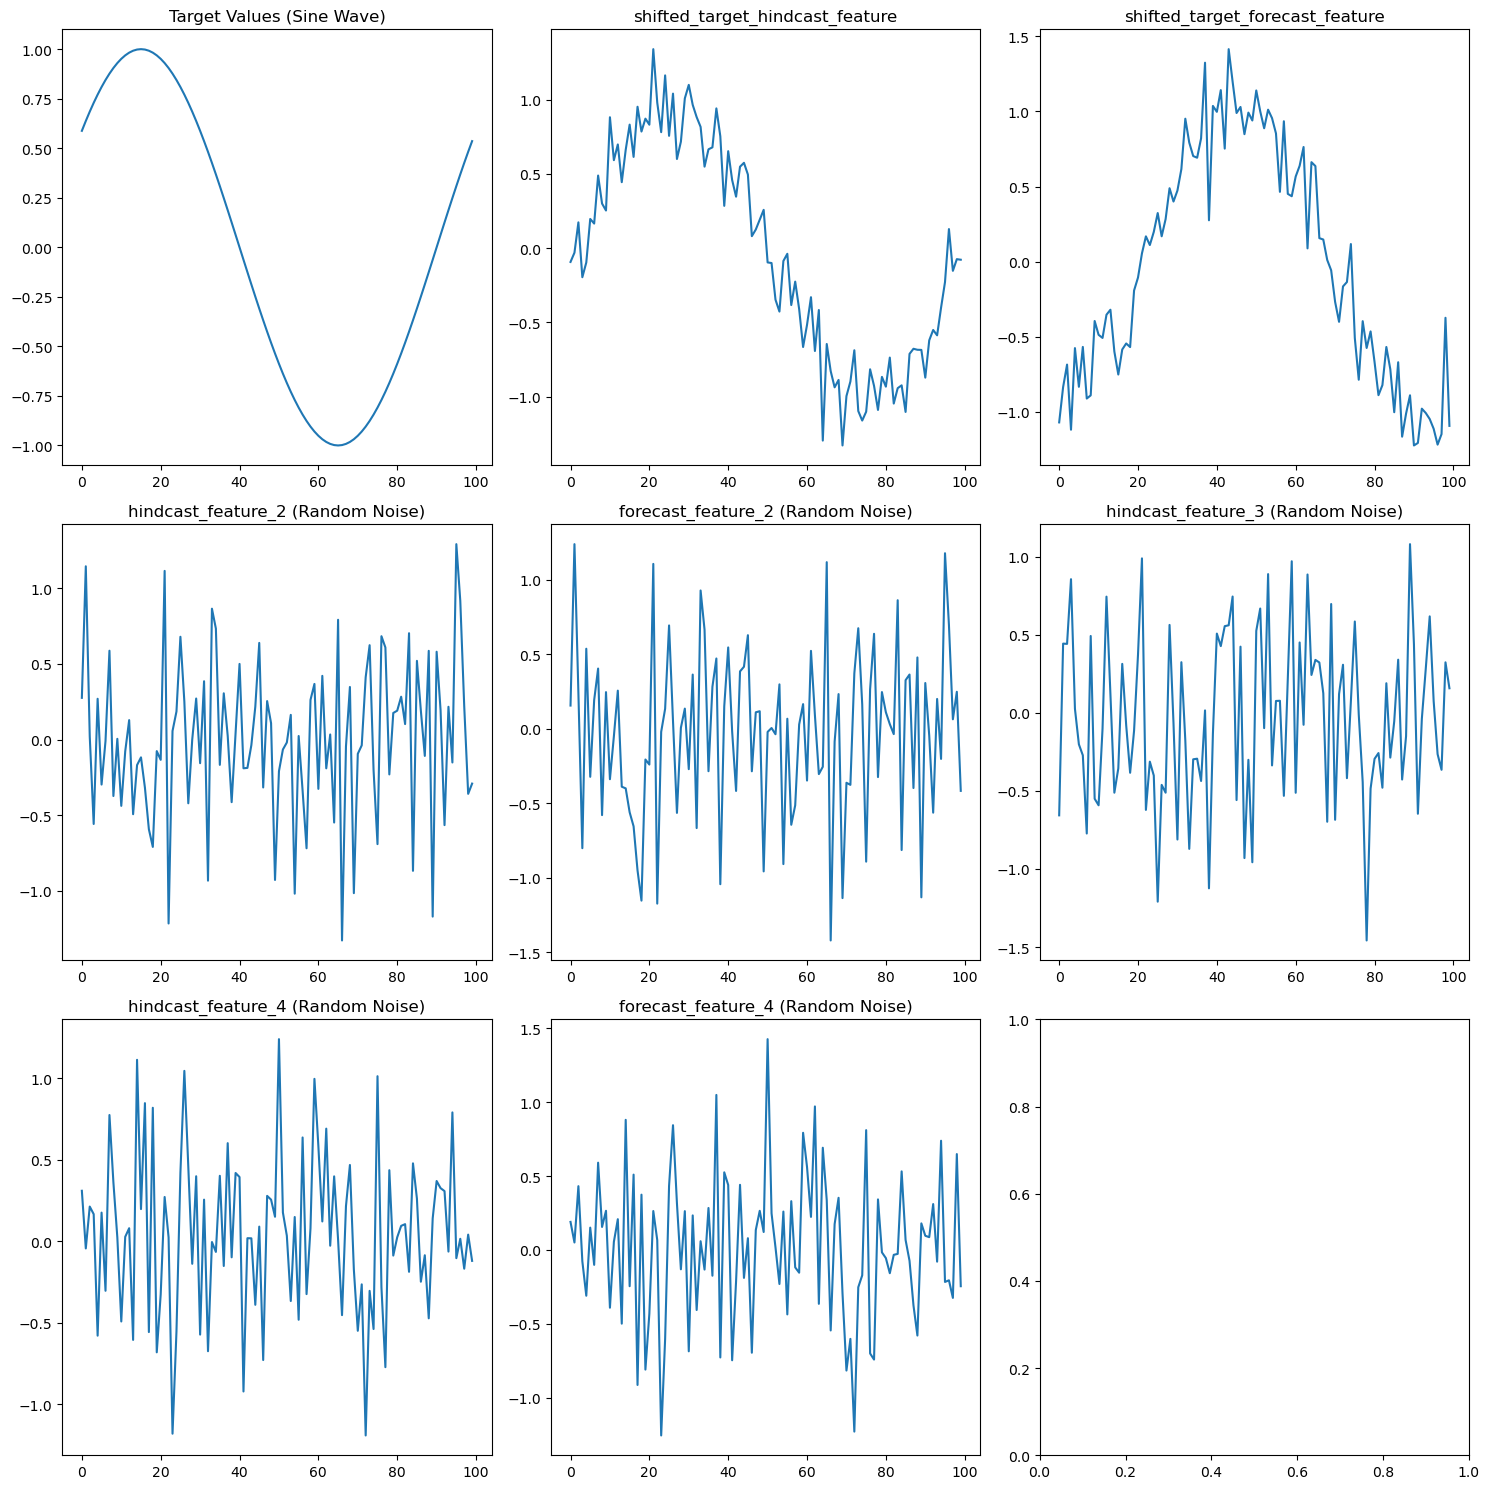

,target,shifted_target_hindcast_feature,shifted_target_forecast_feature,hindcast_feature_2,forecast_feature_2,hindcast_feature_3,hindcast_feature_4,forecast_feature_4
0,0.587785,-0.092684,-1.070621,0.275727,0.156162,-0.656932,0.309335,0.189770
1,0.637424,-0.030355,-0.835285,1.146104,1.240595,0.442311,-0.043993,0.050498
2,0.684547,0.173726,-0.685636,0.020770,0.239961,0.440659,0.212536,0.431727
3,0.728969,-0.195275,-1.119340,-0.558963,-0.801996,0.854787,0.166127,-0.076907
4,0.770513,-0.096294,-0.575857,0.269529,0.538000,0.025017,-0.578408,-0.309937
...,...,...,...,...,...,...,...,...
2985,-0.309017,-0.793521,-0.877579,0.256881,0.188319,-0.120563,-0.396991,-0.465553
2986,-0.248690,-0.718963,-1.065156,-0.102891,-0.323719,0.049370,-0.315401,-0.536229
2987,-0.187381,-0.977321,-0.965189,-0.996517,-1.085400,-0.948180,0.888949,0.800066
2988,-0.125333,-0.617712,-1.264243,-0.776174,-1.135590,1.113808,-0.368130,-0.727546


In [399]:

input_length = 70
output_length = 370

data = make_dataset(time_steps=3000, frequency=0.01, num_features=4, output_length=output_length, shift_steps=10, forecast_noise_sigma=0.2)

plot_data_with_forecast(data)




input_encoder,input_decoder, target = create_input_output_sequences(data, input_length, output_length)
data


In [400]:

# Prepare data
data_dict, stats = prepare_data_for_training(input_encoder,input_decoder, target)
target_mean = stats['target_mean']
target_std = stats['target_std']


In [401]:


# Create datasets and loaders
train_dataset = TimeSeriesForecastDataset(*data_dict['train'])
val_dataset = TimeSeriesForecastDataset(*data_dict['val'])
test_dataset = TimeSeriesForecastDataset(*data_dict['test'])

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


# Define input sizes
hindcast_input_size = data_dict['train'][0].shape[2]  # Number of hindcast features
forecast_input_size = data_dict['train'][1].shape[2]  # Number of forecast features

print('hindcast_input_size: ', hindcast_input_size)
print('forecast_input_size: ', forecast_input_size)


output_size = 1
hidden_size = 64
num_layers = 1


# Instantiate the encoder and decoder
encoder = Encoder(
    input_size=hindcast_input_size,
    hidden_size=hidden_size,
    num_layers=num_layers
)

decoder = Decoder(
    output_size=output_size,
    future_feature_size=forecast_input_size,
    hidden_size=hidden_size,
    num_layers=num_layers
)

# Instantiate the encoder-decoder model
model = EncoderDecoderModel(encoder, decoder, target_len=output_length)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
teacher_forcing_ratio = 0.5
# Train the model
train_model(model, num_epochs, teacher_forcing_ratio, criterion, optimizer, train_loader)

hindcast_input_size:  4
forecast_input_size:  3
Epoch [1/10], Loss: 0.755914
Epoch [2/10], Loss: 0.066674
Epoch [3/10], Loss: 0.021222
Epoch [4/10], Loss: 0.010777
Epoch [5/10], Loss: 0.005391
Epoch [6/10], Loss: 0.002888
Epoch [7/10], Loss: 0.001876
Epoch [8/10], Loss: 0.001594
Epoch [9/10], Loss: 0.001425
Epoch [10/10], Loss: 0.001368


In [402]:

# Evaluate the model
predictions_norm, actuals_norm = eval_model(model, criterion, test_loader)

# Inverse transform
def inverse_transform(data_norm, mean, std):
    return data_norm * std + mean

predictions = inverse_transform(predictions_norm, target_mean, target_std)
actuals = inverse_transform(actuals_norm, target_mean, target_std)


Test Loss: 0.003317


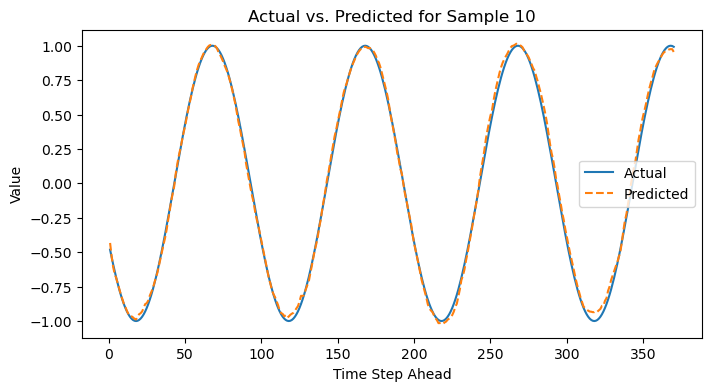

In [406]:

# Plot predictions vs actuals for a sample
sample_idx = 10

plt.figure(figsize=(8, 4))
plt.plot(range(1, output_length + 1), actuals[sample_idx], label='Actual')
plt.plot(range(1, output_length + 1), predictions[sample_idx], label='Predicted', linestyle='--')
plt.legend()
plt.title(f'Actual vs. Predicted for Sample {sample_idx}')
plt.xlabel('Time Step Ahead')
plt.ylabel('Value')
plt.show()

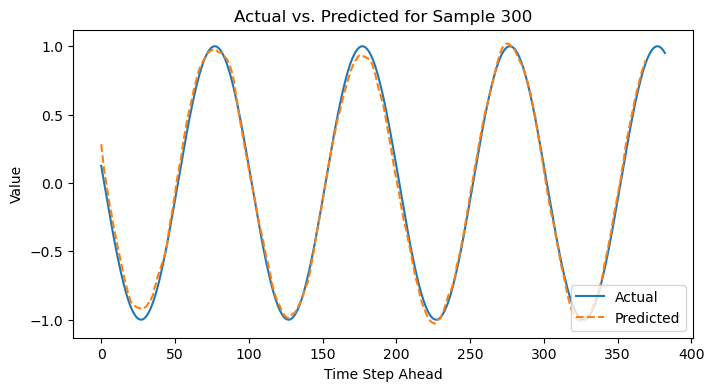

In [410]:
sample_idx = 300
plt.figure(figsize=(8, 4))
plt.plot(actuals[:,sample_idx], label='Actual')
plt.plot(predictions[sample_idx], label='Predicted', linestyle='--')
plt.legend(loc='lower right')
plt.title(f'Actual vs. Predicted for Sample {sample_idx}')
plt.xlabel('Time Step Ahead')
plt.ylabel('Value')
plt.show()